In [12]:
import numpy as np
import json
from pathlib import Path
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [33]:
df = pd.read_csv("/data/home/yanghanlong/data/image_registration/image_id.unmatched.csv", header=None)
print(len(df[0]))
df2 = pd.read_csv("/data/home/yanghanlong/data/image_registration/unmatched.csv", header=None)
df = pd.concat([df,df2], axis=0)
print(len(df))
df.drop_duplicates([0], inplace=True)
print(len(df[0]))
df.to_csv("/data/home/yanghanlong/data/image_registration/image_id.unmatched.csv",index=False,header=False)


2257
2277
2277


In [35]:
##predict by image align(after ptmap)
pred_anno_dir = "/data/home/yanghanlong/data/image_registration/raw_init"
##GroundTruth
gt_anno_dir = "/data/home/yanghanlong/data/image_registration/anno"
##unmatched case(like template update)
unmatched_csv = "/data/home/yanghanlong/data/image_registration/image_id.unmatched.csv"

In [3]:
def calculate_distance(image_id):
    pre_anno = json.load(open(Path(pred_anno_dir).joinpath(image_id+'.json'), 'r'))
    gt_anno = json.load(open(Path(gt_anno_dir).joinpath(image_id+'.json'), 'r'))
    pre_template_pts = pre_anno["template_pts"]
    pre_sample_pts = pre_anno["sample_pts"]
    gt_template_pts = gt_anno["template_pts"]
    gt_sample_pts = gt_anno["sample_pts"]
    ##ignore [Null, Null] in gt_sample_pts
    ignore_pt = [None, None]
    while ignore_pt in gt_sample_pts:
        index = gt_sample_pts.index(ignore_pt)
        del gt_sample_pts[index]
        del pre_sample_pts[index]
    ##transform to np array
    pre_sample_pts = np.array(pre_sample_pts)
    gt_sample_pts = np.array(gt_sample_pts)
    ##calculate distance
    distance = np.average([np.linalg.norm(x - y) for x,y in zip(gt_sample_pts, pre_sample_pts)])
    return distance

In [4]:
##modified distance, divided by sample area
image_dir = "/data/home/yanghanlong/data/image_registration/image"
def calculate_distance2(image_id):
    pre_anno = json.load(open(Path(pred_anno_dir).joinpath(image_id+'.json'), 'r'))
    gt_anno = json.load(open(Path(gt_anno_dir).joinpath(image_id+'.json'), 'r'))
    pre_template_pts = pre_anno["template_pts"]
    pre_sample_pts = pre_anno["sample_pts"]
    gt_template_pts = gt_anno["template_pts"]
    gt_sample_pts = gt_anno["sample_pts"]
    ##ignore [Null, Null] in gt_sample_pts
    ignore_pt = [None, None]
    while ignore_pt in gt_sample_pts:
        index = gt_sample_pts.index(ignore_pt)
        del gt_sample_pts[index]
        del pre_sample_pts[index]
    ##transform to np array
    pre_sample_pts = np.array(pre_sample_pts)
    gt_sample_pts = np.array(gt_sample_pts)
    ##calculate distance
    distance = np.average([np.linalg.norm(x - y) for x,y in zip(gt_sample_pts, pre_sample_pts)])
    # distance = np.linalg.norm(gt_sample_pts - pre_sample_pts)
    ##modify
    im = Image.open(f"{image_dir}/{image_id}.jpg")
    w, h = im.size
    assert w != 0
    distance /= (np.sqrt(w*h)*10e-4)
    return distance

In [5]:
##return a list of distance of each pair of pts
##modified distance, divided by sample area
image_dir = "/data/home/yanghanlong/data/image_registration/image"
def calculate_distance3(image_id):
    pre_anno = json.load(open(Path(pred_anno_dir).joinpath(image_id+'.json'), 'r'))
    gt_anno = json.load(open(Path(gt_anno_dir).joinpath(image_id+'.json'), 'r'))
    pre_template_pts = pre_anno["template_pts"]
    pre_sample_pts = pre_anno["sample_pts"]
    gt_template_pts = gt_anno["template_pts"]
    gt_sample_pts = gt_anno["sample_pts"]
    ##ignore [Null, Null] in gt_sample_pts
    ignore_pt = [None, None]
    while ignore_pt in gt_sample_pts:
        index = gt_sample_pts.index(ignore_pt)
        del gt_sample_pts[index]
        del pre_sample_pts[index]
    ##transform to np array
    pre_sample_pts = np.array(pre_sample_pts)
    gt_sample_pts = np.array(gt_sample_pts)
    ##calculate distance
    distance = [np.linalg.norm(x - y) for x,y in zip(gt_sample_pts, pre_sample_pts)]
    ##modify
    im = Image.open(f"{image_dir}/{image_id}.jpg")
    w, h = im.size
    assert w != 0
    distance = [ x / (np.sqrt(w*h)*10e-4) for x in distance]
    return distance

In [42]:
sum(calculate_distance3("0ef8191e-93fe-4145-ba28-23126a4391a3")) / 16

74.83130881852405

In [43]:
calculate_distance2("0ef8191e-93fe-4145-ba28-23126a4391a3")

74.83130881852404

In [41]:
##handle all files by handle 1 file, choose calculate_distance2/calculate_distance
#unmatched id list
unmatched_list = pd.read_csv(unmatched_csv,header=None)[0].tolist()
jlist = glob.glob(gt_anno_dir+"/*.json")
print(f"Totally {len(jlist)} cases to handle.")
dist_list = []
dist_dict = {}
for jterm in tqdm(jlist):
    image_id = Path(jterm).stem
    #skip unmatched id
    if image_id in unmatched_list:
        continue
    dist = calculate_distance3(image_id) ###CHECK
    dist_list.append(dist)
    dist_dict[image_id] = dist
print(f"finally {len(dist_list)} cases.")


Totally 4993 cases to handle.


100%|██████████| 4993/4993 [00:02<00:00, 2230.32it/s]

finally 4973 cases.


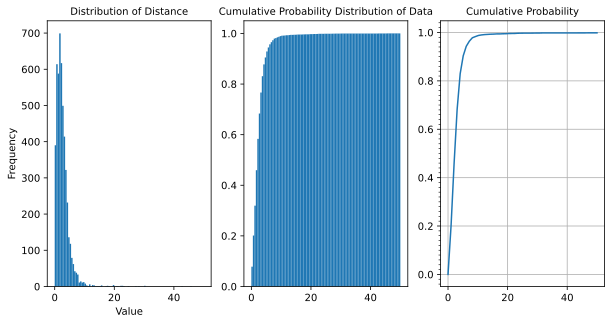

In [8]:
%config InlineBackend.figure_format = 'svg'
# upper_bound = int(max(dist_list))
# print(f"Max value: {upper_bound}")
upper_bound = 50
##visualization
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(10)
ax[0].hist(dist_list, bins=100, range=(0, upper_bound))
ax[1].hist(dist_list, bins=100, range=(0, upper_bound), cumulative=True, density=True)
# 设置图表标题和坐标轴标签
ax[0].set_title("Distribution of Distance", fontsize = 10)
ax[1].set_title("Cumulative Probability Distribution of Data", fontsize = 10)
ax[2].set_title("Cumulative Probability", fontsize = 10)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Frequency")
# ax[2].set_yticks(0.05)
ax[2].yaxis.set_minor_locator(plt.MultipleLocator(0.02))
ax[2].grid(True)
#概率分布曲线图
x = np.linspace(0, upper_bound,upper_bound)
y = np.zeros(upper_bound)
for i in range(upper_bound):
    y[i] = len([x for x in dist_list if x < i]) / len(dist_list)
ax[2].plot(x,y)

In [ ]:
##analysis failure ratio in according with if the case has pts which modified distance > (single_thres)
threshold = range(10, 30, 1)
for i in threshold:
    fail_num = 0
    for j in dist_list:
        if max(j) > i:
            fail_num += 1
    fail_ratio_in_pts = fail_num / len(dist_list)
    print(f"When threshold equals {i}, fail ratio in according with if the case has pt which modified distance > {i}: {fail_ratio_in_pts:.2%}")

In [83]:
##analysis failure ratio in according with how many pt distance exceed 10
threshold = range(1, 17, 1)
single_thres = 5
for i in threshold:
    fail_num = 0
    for j in dist_list:
        fail_pts_num = len([x for x in j if x > single_thres])
        if fail_pts_num > i:
            fail_num += 1
    fail_ratio_in_pts = fail_num / len(dist_list)
    print(f"Fail condition: in one case, there's more than {i} pt_group which m_distance exceed {single_thres}. Fail ratio: {fail_ratio_in_pts:.2%}")

Fail condition: in one case, there's more than 1 pt_group which m_distance exceed 5. Fail ratio: 14.74%
Fail condition: in one case, there's more than 2 pt_group which m_distance exceed 5. Fail ratio: 8.06%
Fail condition: in one case, there's more than 3 pt_group which m_distance exceed 5. Fail ratio: 4.78%
Fail condition: in one case, there's more than 4 pt_group which m_distance exceed 5. Fail ratio: 2.78%
Fail condition: in one case, there's more than 5 pt_group which m_distance exceed 5. Fail ratio: 1.76%
Fail condition: in one case, there's more than 6 pt_group which m_distance exceed 5. Fail ratio: 1.20%
Fail condition: in one case, there's more than 7 pt_group which m_distance exceed 5. Fail ratio: 0.96%
Fail condition: in one case, there's more than 8 pt_group which m_distance exceed 5. Fail ratio: 0.56%
Fail condition: in one case, there's more than 9 pt_group which m_distance exceed 5. Fail ratio: 0.42%
Fail condition: in one case, there's more than 10 pt_group which m_dista

In [10]:
##analysis failure ratio in according with average modified distance in one case
threshold = range(1,30,1)
for i in threshold:
    fail_num = len([x for x in dist_list if x > i])
    fail_ratio_in_pts = fail_num / len(dist_list)
    print(f"When threshold equals {i}, fail ratio in according with average modified distance in one case: {fail_ratio_in_pts:.2%}")

When threshold equals 1, fail ratio in according with average modified distance in one case: 79.89%
When threshold equals 2, fail ratio in according with average modified distance in one case: 54.12%
When threshold equals 3, fail ratio in according with average modified distance in one case: 31.76%
When threshold equals 4, fail ratio in according with average modified distance in one case: 17.02%
When threshold equals 5, fail ratio in according with average modified distance in one case: 9.65%
When threshold equals 6, fail ratio in according with average modified distance in one case: 5.71%
When threshold equals 7, fail ratio in according with average modified distance in one case: 3.63%
When threshold equals 8, fail ratio in according with average modified distance in one case: 2.20%
When threshold equals 9, fail ratio in according with average modified distance in one case: 1.70%
When threshold equals 10, fail ratio in according with average modified distance in one case: 1.24%
When 

In [11]:
for i, j in dist_dict.items():
    if j>10:
        print(i,j)

00e69275-4190-4af4-a620-77aed09dd337 17.972070544297736
0b9f24d5-4d69-4129-8b35-09626e22ab60 72.09697637446352
0ce62dab-07f1-4c15-9e96-87b66b45cf05 17.81717012715753
05431040-48fc-4614-836b-cdc0fbc7b55a 15.501383022175068
06f0a117-49be-4b65-9dc6-c30fcaea0a40 19.728772851929683
0118025f-3f96-4286-bca7-9c54d4166d4a 15.558411808836883
0c8f9180-62b7-4d52-8a19-cf1dbe30efe3 11.78244575844677
0e8d9157-c6e7-4724-b418-be01edbf5c00 23.383953441479107
0989f4c5-09b5-4e89-ab3d-ce1f75d5defe 10.016679581054138
08a050eb-63d8-444b-9391-d44fd0f46d4f 15.997635161579256
0d87545f-89b1-4549-a18b-5f5594705bd7 59.255654702122655
0c9ab7b1-c305-4eab-95c5-0859e90a9217 11.749472905896223
0fe08dda-6fd5-4b98-ace2-4936eab11b41 10.114311659868303
0020bbee-42aa-4975-a973-a542e65aa950 13.309763958564565
01891f1b-fd13-4cdd-ad77-0d83059d2c92 11.536327777969552
00281902-d6b4-4487-bfe4-545a47b98281 11.614685663306503
081e60bf-bc1d-4e52-93d9-9c081565a990 13.667814187447552
03658771-a86e-4369-b5bf-c74f8476f08c 18.02964134726

In [7]:
for i, j in dist_dict.items():
    if 50 < max(j) < 100:
        print(i,max(j))

TypeError: 'numpy.float64' object is not iterable

In [57]:
##for distance3(list)
count = sum([len(x) for x in dist_list])
total = sum([sum(x) for x in dist_list])
print(f"Average distance of all pt pairs: {total/count}")
c = 0
for threshold in range(10, 60,10):
    
    suc_num = sum([(np.array(x) < threshold).sum() for x in dist_list])
    print(f"Recall@{threshold}: {suc_num/count:.3%}")
    c += suc_num/count
c /5

Average distance of all pt pairs: 2.5681699553057973
Recall@10: 97.051%
Recall@20: 99.435%
Recall@30: 99.774%
Recall@40: 99.877%
Recall@50: 99.917%


0.9921104101815377

In [54]:
(np.array(dist_list[0]) > 1).sum()

4